<a href="https://colab.research.google.com/github/plaban1981/Dphi_hackathon/blob/main/Pneumonia_Classification_Challenge_by_Segmind_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pneumonia classification using transfer learning

#### Steps involved

* Take layers from a previously trained model trained on a large dataset
* Freeze previously trained layers to avoid destroying any of the information contained in future training rounds
* Add some new trainable layers on top of frozen layers .These new features will learn task specific features.
* train new layers on custom dataset
* Fine tuning is an optional step which consists of unfreezing the entire model obtained above and retraining it on the new data with a low learning rate


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os

## Download Images

In [2]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [3]:
%%capture
!unzip "/content/drive/MyDrive/AV_Hack/pneumonia_dataset.zip" -d "/content/"

## Import Keras packages

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
import albumentations as A
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import cv2
from google.colab.patches import cv2_imshow
import skimage.exposure
import os
import random

##Image Classification

In [6]:
image_folder = os.listdir("/content/pneumonia_dataset/train")
filename = []
label = []
for folder in image_folder:
  for image_name in os.listdir(os.path.join("/content/pneumonia_dataset/train",folder)):
    filename.append("train/"+folder+"/"+image_name)
    label.append(folder)

##Train data

In [7]:
train_df = pd.DataFrame({'filename':filename,'label':label})
train_df.head()

,filename,label
0,train/normal/CXR_train_687.png,normal
1,train/normal/CXR_train_719.png,normal
2,train/normal/CXR_train_857.png,normal
3,train/normal/CXR_train_2325.png,normal
4,train/normal/CXR_train_1629.png,normal


In [8]:
# shuffle the DataFrame rows
train_df = train_df.sample(frac = 1).reset_index()
train_df.drop('index',axis=1,inplace=True)
train_df.head()

,filename,label
0,train/pneumonia/CXR_train_487.png,pneumonia
1,train/pneumonia/CXR_train_312.png,pneumonia
2,train/pneumonia/CXR_train_928.png,pneumonia
3,train/pneumonia/CXR_train_2139.png,pneumonia
4,train/normal/CXR_train_1059.png,normal


## Viusalize Labels

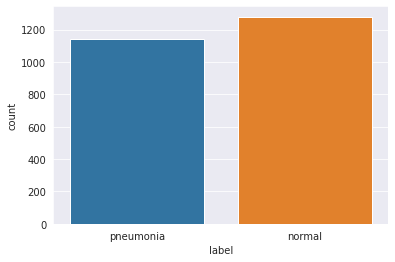

In [9]:
sns.set_style('darkgrid')
sns.countplot(x='label',data=train_df)

## Helper Functions

In [17]:
def visualize(images, transform):
    """
    Plot images and their transformations
    """
    fig = plt.figure(figsize=(32, 16))
    
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 1, xticks=[], yticks=[])
        plt.imshow(im)
        
    for i, im in enumerate(images):
        ax = fig.add_subplot(2, 5, i + 6, xticks=[], yticks=[])
        plt.imshow(transform(image=im)['image'])

In [21]:
train_df.head()

,filename,label
0,train/normal/CXR_train_1093.png,normal
1,train/pneumonia/CXR_train_1723.png,pneumonia
2,train/pneumonia/CXR_train_1884.png,pneumonia
3,train/pneumonia/CXR_train_2401.png,pneumonia
4,train/normal/CXR_train_2089.png,normal


## Visualize sample Data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


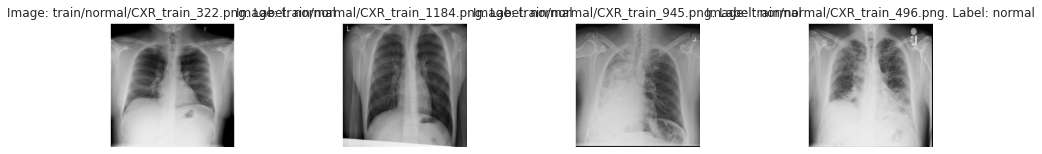

In [23]:
selected_images = []
path = "/content/pneumonia_dataset/"
fig = plt.figure(figsize=(16, 16))
for i in range(5):
    for i, (idx, row) in enumerate(train_df.loc[train_df['label'] == "normal"].sample(4).iterrows()):
        ax = fig.add_subplot(6, 4, 1* 4 + i + 1, xticks=[], yticks=[])
        img = cv2.imread(f"{path}{row['filename']}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        ax.set_title(f"Image: {row['filename']}. Label: {row['label']}")
        if i == 0:
            selected_images.append(img)

## Original Images

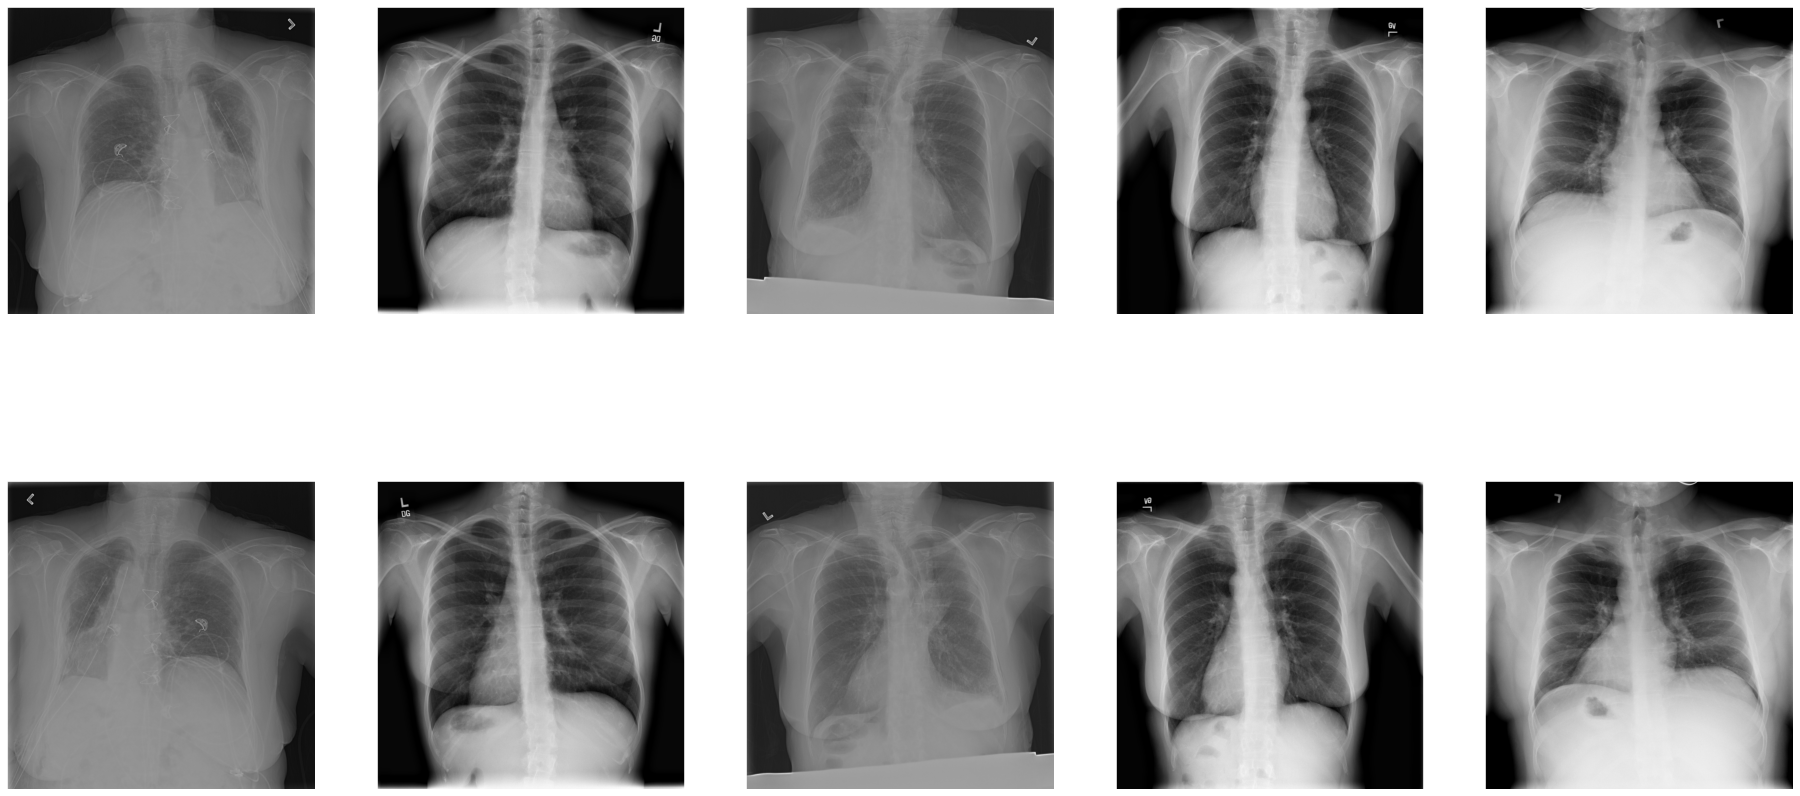

In [24]:
visualize(selected_images, A.HorizontalFlip(p=1))

## Augmented Images

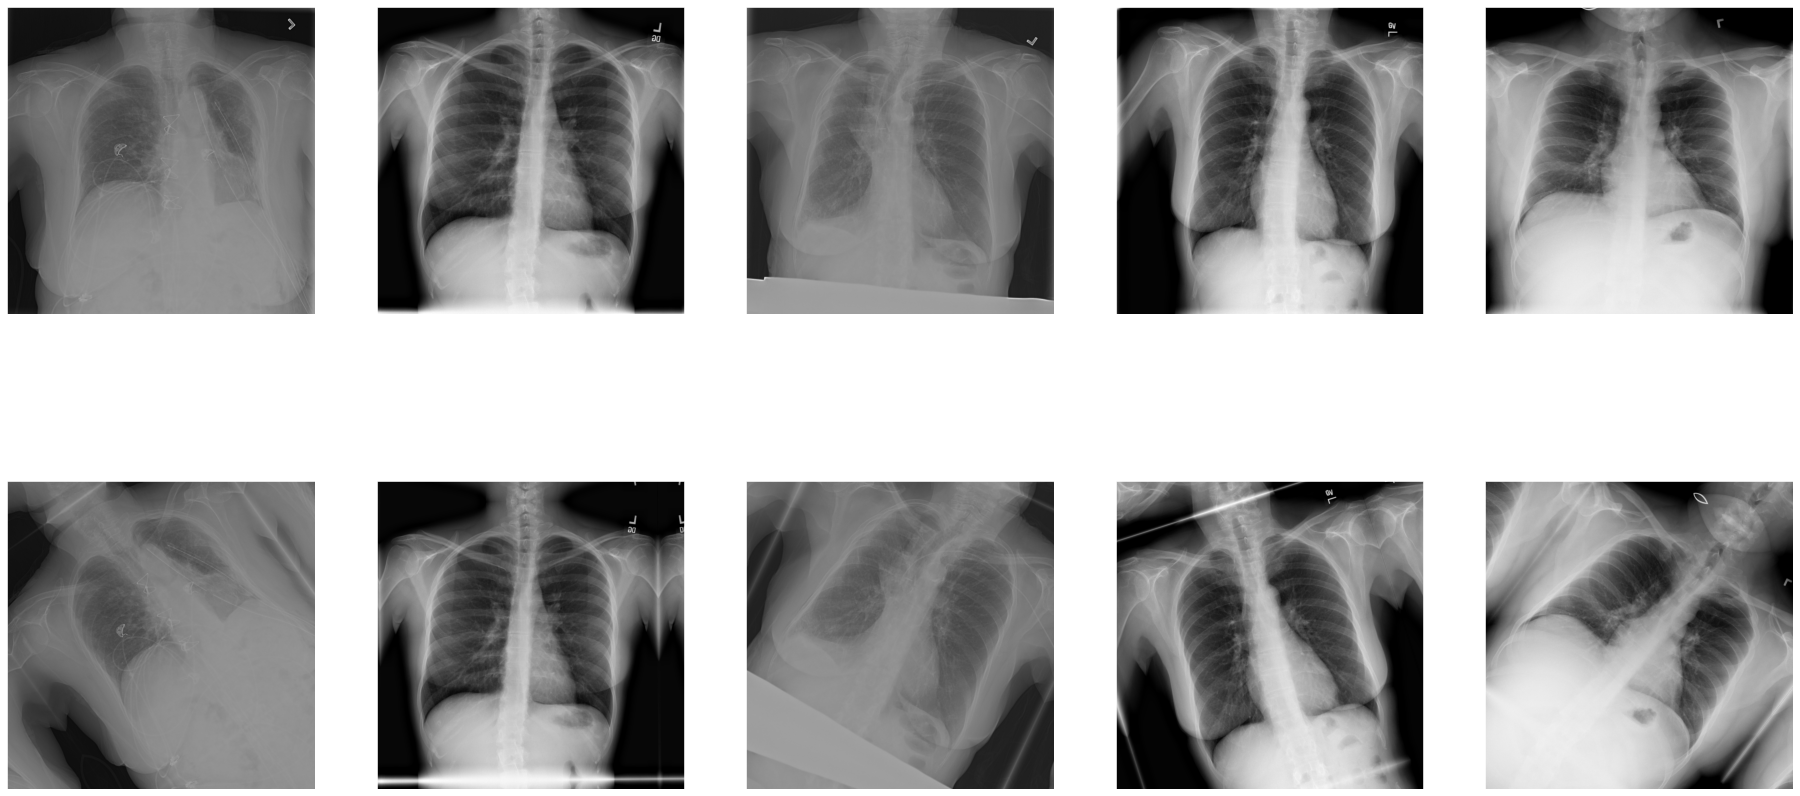

In [25]:
visualize(selected_images, A.ShiftScaleRotate(p=1))

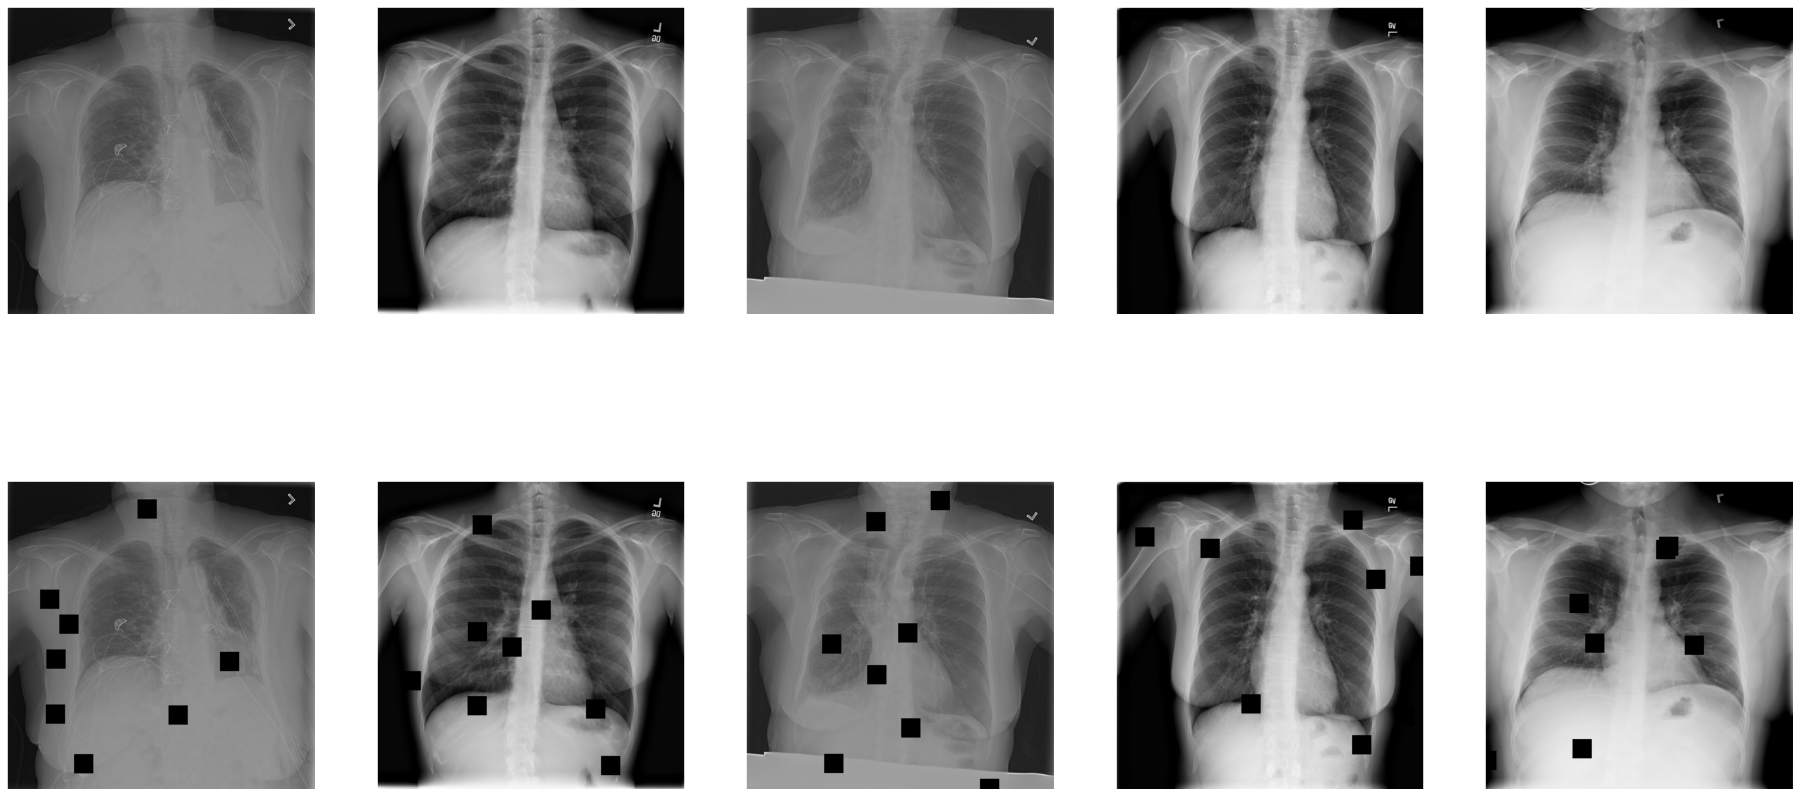

In [26]:
visualize(selected_images, A.Cutout(max_h_size=64, max_w_size=64, p=1))

## Image Preprocessing

* Image normalization can be understood as to how we change an image’s pixel intensity. Often it is linked with increasing contrast, which helps in better image segmentation.

* When you normalize a matrix using NORM_L1, you are dividing every pixel value by the sum of absolute values of all the pixels in the image. As a result, all pixel values become much less than 1 and you get a black image. Try NORM_MINMAX instead of NORM_L1

In [10]:
def preprocess(image):
    kernel = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
    im = cv2.filter2D(image, -1, kernel)
    #out2 = skimage.exposure.rescale_intensity(im, in_range=(150,200), out_range=(0,255))
    out1=(cv2.normalize(im, (224,224),0, 255, cv2.NORM_MINMAX))
    return out1

In [11]:
train_df.to_csv("/content/pneumonia_dataset/train.csv",index=False)

## Train Test Split

In [10]:
X_train, X_valid = train_test_split(train_df, test_size=0.2,random_state=42)

In [11]:
print("len of training set", len(X_train))
print("len of validation set", len(X_valid))

len of training set 1940
len of validation set 485


In [12]:
X_train.head()

,filename,label
2200,train/pneumonia/CXR_train_855.png,pneumonia
1844,train/normal/CXR_train_1040.png,normal
1852,train/pneumonia/CXR_train_2352.png,pneumonia
2345,train/normal/CXR_train_190.png,normal
2004,train/normal/CXR_train_914.png,normal


In [13]:
X_train.label.value_counts(normalize=True)

normal       0.531443
pneumonia    0.468557
Name: label, dtype: float64

In [14]:
X_valid.label.value_counts(normalize=True)

normal       0.513402
pneumonia    0.486598
Name: label, dtype: float64

In [15]:
X_train.to_csv("/content/pneumonia_dataset/train.csv",index=False)
X_valid.to_csv("/content/pneumonia_dataset/valid.csv",index=False)

## Datagenerators

In [27]:
datagen=ImageDataGenerator(rescale=1./255,
                           preprocessing_function=preprocess,
                           #rotation_range=10, # rotation
                           #width_shift_range=0.2, # horizontal shift
                           #height_shift_range=0.2, # vertical shift
                           shear_range=0.2,
                           zoom_range=0.2, # zoom
                           #horizontal_flip=True, # horizontal flip
                           brightness_range=[0.1,1.5], # brightness
                           featurewise_center=True,
                           featurewise_std_normalization=True)

## Image Augmentation - Train datagenerator

In [42]:
train_generator=datagen.flow_from_dataframe(
dataframe=X_train,
directory="/content/pneumonia_dataset",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 1940 validated image filenames belonging to 2 classes.


(224, 224, 3)
(224, 224, 3)


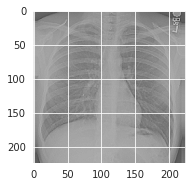

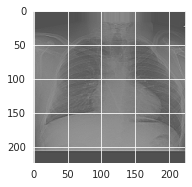

In [43]:
x,y = train_generator.next()
for i in range(2):
    image = x[i]
    plt.figure(figsize=(6,8))
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    print(image.shape)
   
plt.show()

## Validation Datagenerator

In [44]:
valid_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess
                                 )
valid_generator=valid_datagen.flow_from_dataframe( 
dataframe=X_valid,
directory="/content/pneumonia_dataset",
x_col="filename",
y_col="label",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224))

Found 485 validated image filenames belonging to 2 classes.


## Import Keras Libraries

In [29]:
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout,AveragePooling2D
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications import DenseNet121,ResNet152,ResNet101,VGG16,VGG19
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3,DenseNet201,EfficientNetB7, MobileNetV2,Xception,VGG16,NASNetMobile
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Model
from keras.models import Sequential
from keras.regularizers import *
from keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers

## Define Callbacks

In [30]:
checkpoint_path = "training_0/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
my_callbacks = [
               ModelCheckpoint(checkpoint_path, monitor = 'val_get_f1',verbose = 1,save_weights_only=True, save_best_only = True,mode="max"),
               tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=1e-5, verbose=2),
               tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto')
]

## Define step size

In [34]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [31]:
import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Define Model

In [50]:
def build_model():
  model = Sequential()

  conv_base = ResNet101(input_shape=(224,224,3), include_top=False, pooling='max',weights='imagenet')
  model.add(conv_base)
  model.add(BatchNormalization())
  model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
  model.add(BatchNormalization())
  model.add(Dense(2, kernel_regularizer=l1_l2(0.01),activation='softmax'))

  train_layers = [layer for layer in conv_base.layers[::-1][:5]]

  for layer in conv_base.layers:
    if layer in train_layers:
      layer.trainable = True
  return model


## Instantiate Model

In [51]:
model = build_model()
model.summary()

171450368/171446536 [==============================] - 5s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Functional)       (None, 2048)              42658176  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_5 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 4098      
Total params: 46,875,010
Trainable params: 46,761,474
Non-trainable params: 113,536
_________________________________________________________________


## Compile model

In [55]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy',get_f1])

## Train the Model

In [56]:
history = model.fit(
        train_generator,
        steps_per_epoch=STEP_SIZE_TRAIN,
        epochs=30,
        validation_data=valid_generator,
        validation_steps=STEP_SIZE_VALID,callbacks=[my_callbacks])

Epoch 1/30
60/60 [==============================] - 65s 919ms/step - loss: 3.5969 - accuracy: 0.6465 - get_f1: 0.6469 - val_loss: 2.0961 - val_accuracy: 0.5375 - val_get_f1: 0.5375

Epoch 00001: val_get_f1 did not improve from 0.69167
Epoch 2/30
60/60 [==============================] - 54s 895ms/step - loss: 1.6783 - accuracy: 0.7603 - get_f1: 0.7603 - val_loss: 1.7508 - val_accuracy: 0.5146 - val_get_f1: 0.5146

Epoch 00002: val_get_f1 did not improve from 0.69167
Epoch 3/30
60/60 [==============================] - 54s 896ms/step - loss: 1.5212 - accuracy: 0.8030 - get_f1: 0.8030 - val_loss: 1.6643 - val_accuracy: 0.5188 - val_get_f1: 0.5187

Epoch 00003: val_get_f1 did not improve from 0.69167
Epoch 4/30
60/60 [==============================] - 54s 893ms/step - loss: 1.3644 - accuracy: 0.8185 - get_f1: 0.8186 - val_loss: 1.5259 - val_accuracy: 0.6250 - val_get_f1: 0.6250

Epoch 00004: val_get_f1 did not improve from 0.69167
Epoch 5/30
60/60 [==============================] - 54s 890m

In [49]:
model.evaluate(valid_generator,verbose=1)

16/16 [==============================] - 7s 456ms/step - loss: 0.9987 - accuracy: 0.5794 - get_f1: 0.5910


[0.9987288117408752, 0.5793814659118652, 0.5910155773162842]

In [41]:
train_generator.class_indices

{'normal': 0, 'pneumonia': 1}

## Predictions

In [ ]:
test = pd.read_csv("/content/content/pneumonia_dataset/test.csv")

In [ ]:

test_datagen=ImageDataGenerator(rescale=1./255.,preprocessing_function=preprocess)
test_generator=valid_datagen.flow_from_dataframe(
dataframe=test,
directory="/content/content/pneumonia_dataset/test",
x_col="filename",
y_col=None,
batch_size=1,
seed=42,
shuffle=False,
class_mode=None,
target_size=(331,331))
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 606 validated image filenames.


In [ ]:
preds = model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)

606/606 [==============================] - 17s 24ms/step


In [ ]:
preds

array([[0.04756443, 0.9524356 ],
       [0.9639639 , 0.03603604],
       [0.48065028, 0.5193497 ],
       ...,
       [0.17478351, 0.82521653],
       [0.02454729, 0.97545266],
       [0.06124069, 0.9387593 ]], dtype=float32)

In [ ]:
predictions = []
for i in preds:
    predictions.append(np.argmax(i))


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


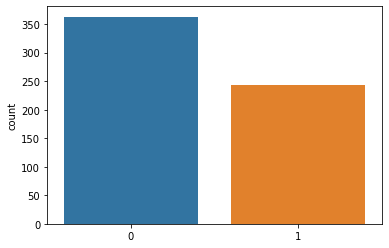

In [ ]:
import seaborn as sns
sns.countplot(predictions)

In [ ]:
train_generator.class_indices

{'normal': 0, 'pneumonia': 1}

In [ ]:
test['label'] = predictions
test['label'] = test['label'].map({0:'normal',1:'pneumonia'})
test.head()

,filename,label
0,CXR_test_519.png,pneumonia
1,CXR_test_578.png,normal
2,CXR_test_359.png,pneumonia
3,CXR_test_573.png,pneumonia
4,CXR_test_471.png,pneumonia


In [ ]:
test.to_csv("keras_densenet121_last.csv",index=False)

**Submission successful! Your score is 64.81744176963427 -NansnetLarge**

**Submission successful! Your score is 68.43844412516353-Densenet121**

**Submission successful! Your score is 72.43856544787377- Resnet152**

In [ ]:
pip install efficientnet-pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=badb816157af871dfbddd1df274f19bdfc5e2dcbccbcb351d960d00b1c448ab4
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


## Fastai

In [ ]:
import warnings
warnings.filterwarnings('ignore')
#
import os
import torch
import numpy as np
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.models.efficientnet import *

In [ ]:
seed = 777
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic =True

In [ ]:
data_path = "/content/content/pneumonia_dataset"
model_path = "/content/training_0"

In [ ]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [ ]:
pneumonia_stats = [(0.356352,0.501708,0.338671),(0.265587,0.249634,0.274386)]

In [ ]:
data =ImageDataBunch.from_folder(data_path,
                                 train="train",
                                 valid_pct =0.2,
                                 test = "test",
                                 size=300,
                                 ds_tfms=get_transforms(),
                                 resize_method=ResizeMethod.SQUISH).normalize(imagenet_stats)

In [ ]:
print(data.classes)

['normal', 'pneumonia']


In [ ]:
print(len(data.train_ds),len(data.valid_ds))

1940 485


In [ ]:
model = EfficientNet.from_pretrained('efficientnet-b3')
model

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth



Loaded pretrained weights for efficientnet-b3


EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        40, 10, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        10, 40, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        40, 24, kernel_siz

In [ ]:
model._fc = nn.Linear(1536,2)

## f1 Score

In [ ]:
fscore = FBeta(average='macro', beta=1)

In [ ]:
learn = cnn_learner(data,
                models.resnet34,
                bn_wd=False,
                metrics=[error_rate, accuracy,fscore],
                loss_func=LabelSmoothingCrossEntropy(),
                callback_fns=[BnFreeze,
                              partial(SaveModelCallback,
                                      monitor='error_rate',
                                      name='best_error')]
                ).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,1.205704,0.849516,0.379381,0.620619,0.616033,00:48
1,1.085122,0.832878,0.364948,0.635052,0.635027,00:48
2,0.918593,0.691269,0.309278,0.690722,0.688036,00:48
3,0.792927,0.669541,0.327835,0.672165,0.670546,00:48
4,0.716290,0.662382,0.319588,0.680412,0.679015,00:48


Better model found at epoch 0 with error_rate value: 0.3793814480304718.
Better model found at epoch 1 with error_rate value: 0.36494845151901245.
Better model found at epoch 2 with error_rate value: 0.30927833914756775.


In [ ]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


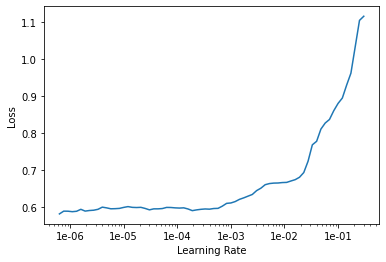

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5,max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.622552,0.665542,0.325773,0.674227,0.670584,00:51
1,0.649700,0.681654,0.379381,0.620619,0.616033,00:51
2,0.633689,0.625606,0.311340,0.688660,0.681644,00:50
3,0.603735,0.604158,0.303093,0.696907,0.696577,00:50
4,0.577828,0.596477,0.292783,0.707217,0.706437,00:50


Better model found at epoch 0 with error_rate value: 0.3257732093334198.
Better model found at epoch 2 with error_rate value: 0.31134021282196045.
Better model found at epoch 3 with error_rate value: 0.3030927777290344.
Better model found at epoch 4 with error_rate value: 0.2927834987640381.


In [ ]:
learn.fit_one_cycle(25,max_lr=slice(1e-5,1e-4),pct_start=0,final_div=1000)

epoch,train_loss,valid_loss,error_rate,accuracy,f_beta,time
0,0.546045,0.601876,0.290722,0.709278,0.708565,00:50
1,0.535233,0.605310,0.307216,0.692784,0.692449,00:50
2,0.525325,0.608721,0.286598,0.713402,0.712576,00:50
3,0.514865,0.613107,0.288660,0.711340,0.711280,00:50
4,0.501300,0.610462,0.284536,0.715464,0.712767,00:50
5,0.488646,0.624601,0.286598,0.713402,0.713383,00:50
6,0.480009,0.608652,0.298969,0.701031,0.699883,00:50
7,0.469704,0.624966,0.301031,0.698969,0.698814,00:50
8,0.462915,0.629442,0.303093,0.696907,0.696887,00:50
9,0.449195,0.628641,0.294845,0.705155,0.704022,00:50


Better model found at epoch 0 with error_rate value: 0.2907216548919678.
Better model found at epoch 2 with error_rate value: 0.28659793734550476.
Better model found at epoch 4 with error_rate value: 0.28453609347343445.


In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score
val_preds, y = learn.TTA(ds_type=DatasetType.Valid)
val_preds = np.exp(val_preds.numpy())
print("F1 score for this fold ",f1_score(y.numpy(), np.argmax(val_preds,axis=1), average='weighted'))
print("Accuracy Score ",accuracy_score(y.numpy(), np.argmax(val_preds,axis=1)))

F1 score for this fold  0.6766483617851423
Accuracy Score  0.6783505154639176


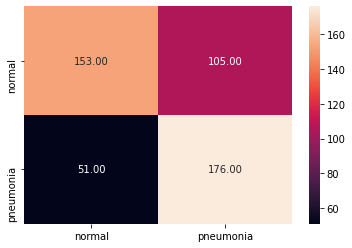

In [ ]:
from sklearn.metrics import *
import seaborn as sns
cf = confusion_matrix(y.numpy(), np.argmax(val_preds,axis=1))
sns.heatmap(cf,annot=True,fmt=".2f",xticklabels=data.classes,yticklabels=data.classes)

## AUTOKERAS

In [16]:
%%capture
!pip install autokeras

In [18]:
import autokeras as ak
print(ak.__version__)

1.0.12


In [20]:
from autokeras import ImageAugmentation,ImageClassifier
import numpy as np
import tensorflow as tf

In [21]:
train_data = ak.image_dataset_from_directory(directory="/content/pneumonia_dataset",
                                             batch_size=32,
                                             color_mode='rgb',
                                             image_size=(256,256),
                                             validation_split=0.2,
                                             subset="training",
                                             seed=42)
valid_data = ak.image_dataset_from_directory(directory="/content/pneumonia_dataset",
                                             batch_size=32,
                                             color_mode='rgb',
                                             image_size=(256,256),
                                             validation_split=0.2,
                                             subset="validation",
                                             seed=42)

Found 3031 files belonging to 2 classes.
Using 2425 files for training.
Found 3031 files belonging to 2 classes.
Using 606 files for validation.


## Customized Search Space

For advanced users, you may customize your search space by using AutoModel instead of ImageClassifier. You can configure the ImageBlock for some high-level configurations, e.g., block_type for the type of neural network to search, normalize for whether to do data normalization, augment for whether to do data augmentation. You can also do not specify these arguments, which would leave the different choices to be tuned automatically. 

In [22]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=False)(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node, outputs=output_node, overwrite=True, max_trials=3
)

In [23]:
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_data, epochs=10)

Trial 3 Complete [00h 41m 39s]
val_loss: 0.6542646288871765

Best val_loss So Far: 0.5405141115188599
Total elapsed time: 02h 03m 52s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
76/76 [==============================] - 244s 3s/step - loss: 3.4189 - accuracy: 0.6942
Epoch 2/10
76/76 [==============================] - 239s 3s/step - loss: 2.2905 - accuracy: 0.7144
Epoch 3/10
76/76 [==============================] - 239s 3s/step - loss: 3.0458 - accuracy: 0.7404
Epoch 4/10
76/76 [==============================] - 239s 3s/step - loss: 1.9527 - accuracy: 0.7169
Epoch 5/10
76/76 [==============================] - 239s 3s/step - loss: 1.0901 - accuracy: 0.7586
Epoch 6/10
76/76 [==============================] - 239s 3s/step - loss: 1.1180 - accuracy: 0.7574
Epoch 7/10
76/76 [==============================] - 239s 3s/step - loss: 0.8337 - accuracy: 0.7611
Epoch 8/10
76/76 [==============================] - 239s 3s/step - loss: 0.7345 - accuracy: 0.7659
Epoch 9/10
76/76 [==================

https://github.com/bsamaha/Chest-Xray-FastAI/blob/master/ChestX_ray_Fastaiv1_Imgclassifier.ipynb

https://www.kaggle.com/avirdee/fastai2-balanced-stratified-submission

In [24]:
print(clf.evaluate(valid_data))

19/19 [==============================] - 34s 2s/step - loss: 1.2228 - accuracy: 0.7261
[1.2228384017944336, 0.7260726094245911]


In [26]:
model = clf.export_model()

In [27]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 256, 256, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 256, 256, 3)       7         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0     

In [32]:
clf = ak.ImageClassifier(overwrite=True, 
                         max_trials=10,
                         metrics=['accuracy',get_f1],
                         )

In [ ]:
clf.fit(train_data, epochs=10,callbacks=[my_callbacks])

Trial 4 Complete [00h 22m 03s]
val_loss: 0.5288791656494141

Best val_loss So Far: 0.5288791656494141
Total elapsed time: 01h 47m 15s

Search: Running Trial #5

Hyperparameter    |Value             |Best Value So Far 
image_block_1/n...|True              |True              
image_block_1/a...|True              |True              
image_block_1/b...|resnet            |resnet            
image_block_1/r...|False             |False             
image_block_1/r...|resnet50          |resnet50          
image_block_1/r...|True              |True              
classification_...|global_max        |global_avg        
classification_...|0.25              |0                 
optimizer         |adam              |adam              
learning_rate     |0.001             |0.001             
image_block_1/i...|0.1               |0.1               
image_block_1/i...|True              |True              
image_block_1/i...|True              |True              
image_block_1/i...|0                 |0  

In [ ]:
best = clf.load_searcher().load_best_model()